# Automatic Translation

## Make workspace

In [1]:
# Make directories if they don't exist
!mkdir -p datasets
!mkdir -p plot
!mkdir -p model

[]

## Imports

In [2]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

## Download datasets

Translation dataset used in original paper can be found [here](https://www.tensorflow.org/datasets/catalog/wmt14_translate)

In [62]:
# Download english language word list
if not os.path.exists('datasets/source_dictionary.txt'):
    !cd datasets && curl -o source_dictionary.txt https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current',
 '                                 Dload  Upload   Total   Spent    Left  Speed',
 '',
 '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0',
 '  0 4135k    0  2742    0     0   2742      0  0:25:44 --:--:--  0:25:44  6274',
 '100 4135k  100 4135k    0     0  4135k      0  0:00:01  0:00:01 --:--:-- 3484k']

In [4]:
# Download french language word list
if not os.path.exists('datasets/target_dictionary.tsv'):
    !cd datasets && curl -O http://www.lexique.org/databases/Lexique383/Lexique383.zip
    !cd datasets && unzip Lexique383.zip
    !mv datasets/Lexique383.tsv datasets/target_dictionary.tsv

In [5]:
# Download english-to-french translation dataset
if not os.path.exists('datasets/translation.txt'):
    !cd datasets && curl -O http://www.manythings.org/anki/fra-eng.zip
    !cd datasets && unzip fra-eng.zip fra.txt
    !mv datasets/fra.txt datasets/translation.txt

[]

In [5]:
# Download english word embeddings
if not os.path.exists('datasets/glove.6B.100d.txt'):
    !cd datasets && curl -LO http://nlp.stanford.edu/data/glove.6B.zip
    !cd datasets && unzip glove.6B.zip glove.6B.100d.txt

## Preprocessing

Sentences from the source and destination languages are converted to token sequences and padded to the same length. Source sentences are padded on the left and destination sentences on the right. Special tokens representing words not in dicionary (\<unk\>), start of sequence (\<sos\>) and end of sequence (\<eos\>) are added to the destination sentences. There are two generated destination sentences, one for decoder input (which has the start token appended), and one for decoder ouput (which has the end token appended). Source language sequences are reversed for better results.

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### English word list

In [64]:
# Word list for source language
source_words = []

# Load source language word list and convert characters to lower
with open('datasets/source_dictionary.txt') as f:
    source_words = f.read().lower().split('\n')
print(source_words[:20])

# Make source language tokenizer. UNK token is 1
source_tokenizer = Tokenizer(num_words=len(source_words), oov_token=1)
source_tokenizer.fit_on_texts(source_words)

['a', 'aa', 'aaa', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalii', 'aaliis', 'aals', 'aam', 'aani', 'aardvark', 'aardvarks', 'aardwolf', 'aardwolves', 'aargh', 'aaron', 'aaronic']


### French word list

In [61]:
# Word list for target language
target_words = []

# Load target language word list and convert characters to lower
df = pd.read_csv('datasets/target_dictionary.tsv', sep='\t', keep_default_na=False)['ortho'].tolist()
target_words = [w.lower() for w in df]
print(target_words[:20])

# Make target language tokenizer. UNK token is 1
target_tokenizer = Tokenizer(num_words=len(target_words), oov_token=1)
target_tokenizer.fit_on_texts(target_words)

['a', 'a', 'a', 'a capella', 'a cappella', 'a contrario', 'a fortiori', 'a giorno', 'a jeun', "a l'instar", 'a posteriori', 'a priori', 'a priori', 'aa', 'ab absurdo', 'ab initio', 'ab ovo', 'abaca', 'abaissa', 'abaissai']


### English-to-French translation dataset

In [8]:
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

In [9]:
source_sentences = []
target_sentences_input = []
target_sentences_output = []

lines = []
with open('datasets/translation.txt') as f:
    lines = f.read().split('\n')

# TODO remove limit after testing
NUM_LINES = 20_000
for line in lines[:NUM_LINES]:
    input_sentence, target_sentence, _ = line.split('\t')
    source_sentences.append(input_sentence)
    target_sentences_input.append(SOS_TOKEN + ' ' + target_sentence)
    target_sentences_output.append(target_sentence + ' ' + EOS_TOKEN)

In [10]:
MAX_NUM_SOURCE_WORDS = 50_000
MAX_NUM_TARGET_WORDS = 50_000

In [11]:
# Make source language tokenizer
source_tokenizer = Tokenizer(num_words=MAX_NUM_SOURCE_WORDS)
source_tokenizer.fit_on_texts(source_sentences)
source_dict = source_tokenizer.word_index
NUM_SOURCE_WORDS = len(source_dict)+1

# Make destination language tokenizer
# Don't filter '<' and '>' because they're used for SOS and EOS tokens
target_tokenizer = Tokenizer(num_words=MAX_NUM_TARGET_WORDS, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
target_tokenizer.fit_on_texts(target_sentences_input + target_sentences_output)
target_dict = target_tokenizer.word_index
NUM_TARGET_WORDS = len(target_dict)+1

In [12]:
print(len(source_dict))
print(len(target_dict))
print(source_dict)
print(target_dict)

3494
7216
{'i': 1, 'you': 2, 'a': 3, 'it': 4, 'is': 5, 'tom': 6, "i'm": 7, 'he': 8, "you're": 9, 'me': 10, 'are': 11, 'the': 12, 'we': 13, 'was': 14, 'this': 15, 'do': 16, 'that': 17, 'to': 18, "it's": 19, 'go': 20, "don't": 21, 'have': 22, "we're": 23, 'your': 24, 'not': 25, 'my': 26, 'be': 27, 'can': 28, 'no': 29, 'did': 30, 'they': 31, 'all': 32, 'she': 33, 'here': 34, 'like': 35, 'up': 36, 'in': 37, "i'll": 38, 'what': 39, 'him': 40, 'need': 41, "that's": 42, 'on': 43, 'get': 44, 'how': 45, 'very': 46, 'love': 47, 'come': 48, "he's": 49, 'want': 50, 'one': 51, 'got': 52, "can't": 53, 'let': 54, 'us': 55, 'so': 56, 'am': 57, "they're": 58, 'out': 59, 'stop': 60, 'look': 61, 'now': 62, 'please': 63, 'too': 64, 'see': 65, 'who': 66, 'just': 67, 'know': 68, 'feel': 69, 'help': 70, 'had': 71, 'take': 72, 'good': 73, 'home': 74, 'will': 75, 'there': 76, 'try': 77, 'hate': 78, 'give': 79, 'must': 80, 'for': 81, "let's": 82, "tom's": 83, 'has': 84, 'were': 85, 'happy': 86, 'at': 87, 'busy'

In [13]:
# Tokenize sentences to sequences
source_sequences = source_tokenizer.texts_to_sequences(source_sentences)
target_sequences_input = target_tokenizer.texts_to_sequences(target_sentences_input)
target_sequences_output = target_tokenizer.texts_to_sequences(target_sentences_output)

# Reverse source sequnces
for sequence in source_sequences:
    sequence.reverse()

max_source_len = max([len(sequence) for sequence in source_sequences])
max_target_len = max([len(sequence) for sequence in target_sequences_output])

encoder_input_sequences = pad_sequences(source_sequences, maxlen=max_source_len, padding='pre')
decoder_input_sequences = pad_sequences(target_sequences_input, maxlen=max_target_len, padding='post')
decoder_output_sequences = pad_sequences(target_sequences_output, maxlen=max_target_len, padding='post')

In [104]:
print(max_source_len)
print(max_target_len)

5
12


In [105]:
for i in range(0, 10):
    print(source_sentences[i])
    print(str(encoder_input_sequences[i]))
    print(target_sentences_input[i])
    print(str(decoder_input_sequences[i]))

Go.
[ 0  0  0  0 20]
<sos> Va !
[ 1 54  0  0  0  0  0  0  0  0  0  0]
Hi.
[  0   0   0   0 853]
<sos> Salut !
[  1 841   0   0   0   0   0   0   0   0   0   0]
Hi.
[  0   0   0   0 853]
<sos> Salut.
[  1 841   0   0   0   0   0   0   0   0   0   0]
Run!
[  0   0   0   0 158]
<sos> Coursâ€¯!
[   1 3816    0    0    0    0    0    0    0    0    0    0]
Run!
[  0   0   0   0 158]
<sos> Courezâ€¯!
[   1 3817    0    0    0    0    0    0    0    0    0    0]
Who?
[ 0  0  0  0 66]
<sos> Qui ?
[ 1 36  0  0  0  0  0  0  0  0  0  0]
Wow!
[   0    0    0    0 2440]
<sos> Ã‡a alorsâ€¯!
[   1   39 3818    0    0    0    0    0    0    0    0    0]
Fire!
[  0   0   0   0 528]
<sos> Au feu !
[  1  76 517   0   0   0   0   0   0   0   0   0]
Help!
[ 0  0  0  0 70]
<sos> Ã€ l'aideâ€¯!
[   1  199 3819    0    0    0    0    0    0    0    0    0]
Jump.
[  0   0   0   0 854]
<sos> Saute.
[   1 1910    0    0    0    0    0    0    0    0    0    0]


## Model Building

The most common model for neural machine translation (NMT) is the sequence-to-sequence model which is a combination of recurrent neural network and encoder-decoder architectures. The enocder maps variable-length input sequence to a fixed-length representation, and the decoder uses that representation to generate an output sequence one word at a time.

This type of model is used by Google for its translation service (https://arxiv.org/pdf/1609.08144.pdf, https://ai.googleblog.com/2016/09/a-neural-network-for-machine.html).

In [97]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense 

In [ ]:
# Number of tokens is expected to be 1 greater than the number of words
n_encoder_tokens = len(source_dict)+1
n_decoder_tokens = len(target_dict)+1

EMBEDDING_DIM = 100
LSTM_DIM = 256

### Embedding layer

Keras documentation: https://keras.io/api/layers/core_layers/embedding/

Turns positive integers (indexes) into dense vectors of fixed size.

e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

This layer can only be used as the first layer in a model.

Arguments:
- **input_dim**: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- **output_dim**: Integer. Dimension of the dense embedding.

### LSTM layer

Keras documentation: https://keras.io/api/layers/recurrent_layers/lstm/

Long Short-Term Memory layer

Arguments:
- **units**: Positive integer, dimensionality of the output space.
- **kernel_initializer**: Initializer for the kernel weights matrix
- **return_sequences**: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
- **return_state**: Boolean. Whether to return the last state in addition to the output. Default: False.

return_state returns the lstm output, last hidden state and last cell state and return_sequences returns hidden states for each step as the main output. Both flags can be used at the same time and will return all hidden states, last hidden state and last cell state.

For more information on return_sequences and return_state read [this](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)

### Layer initializers

Keras documentation: https://keras.io/api/layers/initializers/

Initializers define the way to set the initial random weights of Keras layers.

Some of the available initializers:
- RandomNormal
- RandomUniform
- Zeros
- Ones

### GloVe Embeddings

Instead of learning the embeddings for english words during training, a pre-trained model called [GloVe](https://nlp.stanford.edu/projects/glove/) will be used. It has been trained on 6 billion words from [Wikipedia 2014](https://dumps.wikimedia.org/enwiki/latest/) and [Gigaworld 5](https://catalog.ldc.upenn.edu/LDC2011T07). The french word embeddings will be learned during training.

In [ ]:
embeddings_dict = {}
with open('datasets/glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        record = line.split()
        word = record[0]
        word_embedding = np.asarray(record[1:], dtype='float32')
        embeddings_dict[word] = word_embedding

In [ ]:
embedding_matrix = np.zeros((n_encoder_tokens, EMBEDDING_DIM))
for word, index in source_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
print(embeddings_dict["hello"])

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.27326    0.15636   -0.20334
  0.53586    0.59784   

### Encoder

In [110]:
encoder_inputs = Input(shape=(max_source_len,))
encoder_embedding = Embedding(n_encoder_tokens, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_source_len)
encoder_lstm = LSTM(
    LSTM_DIM,
    # kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None),
    return_state=True
)

encoder = encoder_embedding(encoder_inputs)
encoder, state_h, state_c = encoder_lstm(encoder)

encoder_states = [state_h, state_c]

### Decoder

In [111]:
decoder_inputs = Input(shape=(max_target_len,))
decoder_embedding = Embedding(n_decoder_tokens, EMBEDDING_DIM)
decoder_lstm = LSTM(
    LSTM_DIM, 
    # kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None),
    return_sequences=True,
    return_state=True
)
decoder_dense = Dense(n_decoder_tokens, activation='softmax')

decoder = decoder_embedding(decoder_inputs)
decoder, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
decoder = decoder_dense(decoder)

### Model

In [112]:
model = Model([encoder_inputs, decoder_inputs], decoder)

# It is possible to use beam search during training by definig a custom loss function
# https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618

# TODO Make adaptive learning rate using keras.callbacks.LearningRateScheduler
# https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
# TODO Use SGD optimizer with no momentum, start rate 0.7
# https://keras.io/api/optimizers/sgd/
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [113]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 5, 100)       349500      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 12, 100)      721700      input_2[0][0]                    
_______________________________________________________________________________________

### Plot the model

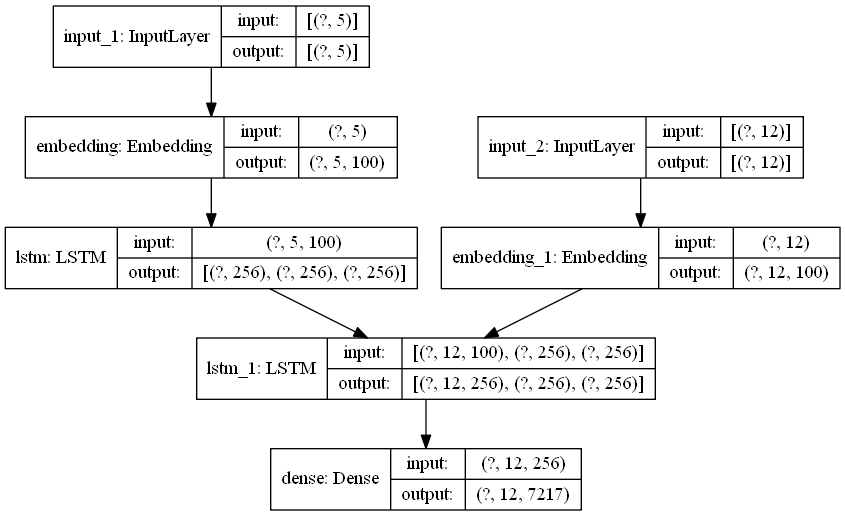

In [114]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plot/model.png', show_shapes=True, show_layer_names=True)

## Model Training

In [115]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_output_sequences.shape)

(20000, 5)
(20000, 12)
(20000, 12)


In [117]:
# Experimental
EPOCHS = 10
BATCH_SIZE = 64

VALIDATION_SPLIT = 0.1

In [108]:
# Decoder outputs need to be one-hot-encoded for the dense softmax layer to work
from tensorflow.keras.utils import to_categorical
decoder_output = np.array([to_categorical(output, num_classes=n_decoder_tokens) for output in decoder_output_sequences])

In [109]:
print(target_dict)
print(target_sentences_output[0])
print(decoder_output_sequences[0])
print(decoder_output[0])
print(decoder_output.shape)

{'<sos>': 1, '<eos>': 2, 'je': 3, 'vous': 4, 'est': 5, 'il': 6, 'pas': 7, 'nous': 8, 'suis': 9, 'tom': 10, 'le': 11, 'tu': 12, 'ne': 13, 'de': 14, "c'est": 15, "j'ai": 16, 'un': 17, 'la': 18, 'ce': 19, 'a': 20, 'ã\xa0': 21, 'me': 22, 'en': 23, 'les': 24, 'ãªtes': 25, 'une': 26, 'es': 27, 'moi': 28, 'sommes': 29, 'que': 30, 'elle': 31, 'sont': 32, 'fait': 33, 'ã§a': 34, 'ils': 35, 'qui': 36, 'tout': 37, 'des': 38, 'ã‡a': 39, 'elles': 40, 'mon': 41, "n'est": 42, 'y': 43, 'te': 44, 'toi': 45, 'peux': 46, 'bien': 47, 'ici': 48, 'ai': 49, 'ã©tã©': 50, 'du': 51, 'faut': 52, 'besoin': 53, 'va': 54, 'trã¨s': 55, 'ãštes': 56, 'as': 57, 'fais': 58, 'veux': 59, 'faire': 60, 'avons': 61, 'personne': 62, 'se': 63, "j'aime": 64, "l'air": 65, 'cela': 66, 'avez': 67, "l'ai": 68, 'tous': 69, 'votre': 70, 'soyez': 71, 'aller': 72, 'lã\xa0': 73, 'comment': 74, 'train': 75, 'au': 76, 'trop': 77, 'ton': 78, 'sens': 79, "j'ã©tais": 80, 'on': 81, 'dã©teste': 82, 'ã©tait': 83, 'sois': 84, 'lui': 85, 'maintena

In [ ]:
model.load_weights('model/translator_weights')

In [ ]:
keras.models.load_model('model/translator')

In [118]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)
history = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_output,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    callbacks=[checkpoint_callback]
)
model.save(f'model/tranlator_{NUM_LINES}_{EPOCHS}_{BATCH_SIZE}_{VALIDATION_SIZE}_{time.strftime("%Y%m%d_%H%M%S")}')

Epoch 1/20
282/282 [==============================] - 710s 3s/step - loss: 2.1488 - accuracy: 0.6961 - val_loss: 2.2095 - val_accuracy: 0.6708
Epoch 2/20
282/282 [==============================] - 699s 2s/step - loss: 1.6392 - accuracy: 0.7492 - val_loss: 1.9968 - val_accuracy: 0.7028
Epoch 3/20
282/282 [==============================] - 693s 2s/step - loss: 1.4599 - accuracy: 0.7736 - val_loss: 1.8791 - val_accuracy: 0.7205
Epoch 4/20
282/282 [==============================] - 707s 3s/step - loss: 1.3369 - accuracy: 0.7902 - val_loss: 1.7773 - val_accuracy: 0.7335
Epoch 5/20
282/282 [==============================] - 708s 3s/step - loss: 1.2357 - accuracy: 0.8029 - val_loss: 1.7167 - val_accuracy: 0.7423
Epoch 6/20
282/282 [==============================] - 750s 3s/step - loss: 1.1562 - accuracy: 0.8128 - val_loss: 1.6506 - val_accuracy: 0.7547
Epoch 7/20
282/282 [==============================] - 714s 3s/step - loss: 1.0927 - accuracy: 0.8213 - val_loss: 1.6274 - val_accuracy: 0.7587

In [231]:
model.save_weights('model/translator_weights')

In [ ]:
model.save('model/translator')

In [120]:
import matplotlib.pyplot as plt

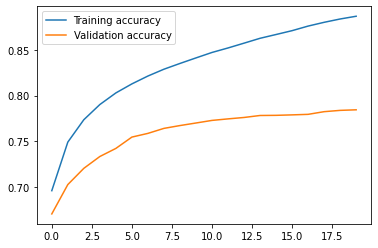

In [121]:
plt.plot(history.epoch, history.history['accuracy'])
plt.plot(history.epoch, history.history['val_accuracy'])
plt.legend(['Training accuracy', 'Validation accuracy'])

## Inference

### Build the model

To predict outputs a separate model is needed because the previous decoder output has to be passed in as an input for the next word

In [122]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_h = Input(shape=(LSTM_DIM,))
decoder_state_c = Input(shape=(LSTM_DIM,))
decoder_states = [decoder_state_h, decoder_state_c]

decoder_input_word = Input(shape=(1,))

inference_decoder = decoder_embedding(decoder_input_word)
inference_decoder, state_h, state_c = decoder_lstm(inference_decoder, initial_state=decoder_states)
inference_decoder = decoder_dense(inference_decoder)

inference_states = [state_h, state_c]

decoder_model = Model(
    [decoder_input_word] + decoder_states,
    [inference_decoder] + inference_states
)

In [123]:
encoder_model.summary()
decoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 5, 100)            349500    
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 365568    
Total params: 715,068
Trainable params: 715,068
Non-trainable params: 0
_________________________________________________________________
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
___________________________________________________________

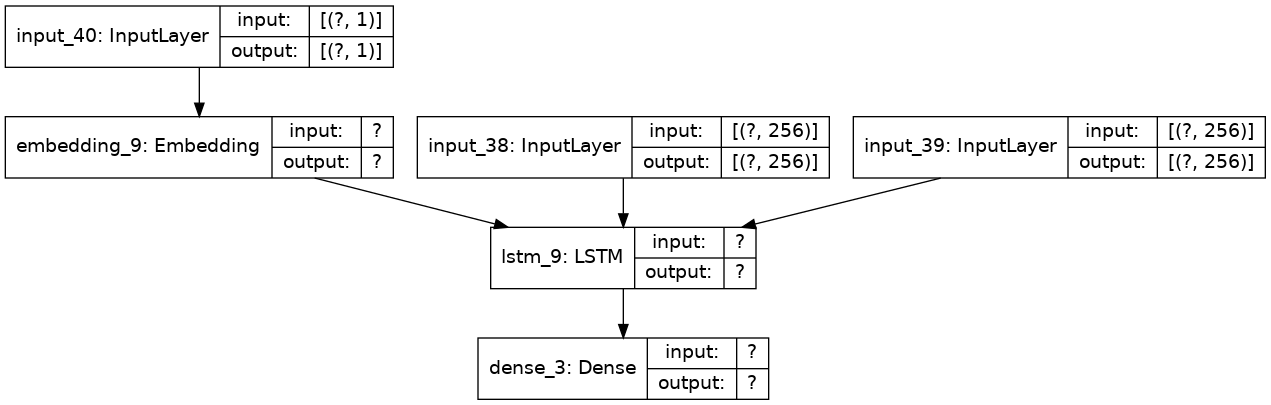

In [234]:
plot_model(decoder_model, to_file='plot/inference_model.png', show_shapes=True, show_layer_names=True)

### Greedy Search

In [124]:
reverse_source_dict = { v:k for k,v in source_dict.items() }
reverse_target_dict = { v:k for k,v in target_dict.items() }

In [212]:
def sentence_to_sequence(sentence):
    sequence = source_tokenizer.texts_to_sequences([sentence])
    sequence.reverse()
    sequence = pad_sequences([sequence], maxlen=max_source_len, padding='pre')
    return sequence

In [213]:
def sequence_to_sentence(sequence):
    SOS_ID = target_dict[SOS_TOKEN]
    EOS_ID = target_dict[EOS_TOKEN]
    words = []
    for i in sequence:
        if i == SOS_ID:
            continue
        elif i == EOS_ID:
            break
        elif i > 0:
            words.append(reverse_target_dict[i])
        else:
            words.append(UNK_TOKEN)
    return ' '.join(words)

In [211]:
def predict_sequence(source_sequence):
    # Predict the encoder result directly
    current_state = encoder_model.predict(source_sequence)
    
    # Predict ouput words one at a time until <eos> token or max_target_len
    EOS_ID = target_dict[EOS_TOKEN]
    
    # Decoder_model expects a tensor as input
    decoder_input = np.zeros((1, 1))
    decoder_input[0, 0] = target_dict[SOS_TOKEN]
    target_sequence = []
    
    for _ in range(max_target_len):
        dense_outputs, state_h, state_c = decoder_model.predict([decoder_input] + current_state)
        token = np.argmax(dense_outputs[0, 0, :])
        if token == EOS_ID:
            break
        else:
            target_sequence.append(token)
        
        # Replace decoder inputs to last generated token and states
        decoder_input[0, 0] = token
        current_state = [state_h, state_c]
    return target_sequence

def predict(source_sequence):
    target_sequence = predict_sequence(source_sequence)
    return sequence_to_sentence(target_sequence)

### Beam Search

The beam search algorithm is used as an improvement to the greedy search algorithm for determining the next word in the sequence. It works by taking the k best options at each step and then using those for all next steps. The best options are evalueted by maximizing the average log probability of each word is the output. For k=1 this is equivalent to the greedy algorithm. Increasing the k value gives better results but also increases processing time exponentially.

In [214]:
def beam_search_predict_sequence(source_sequence, k=1):
    encoder_output_state = encoder_model.predict([source_sequence])
    decoder_input = np.zeros((1, 1))
    
    # (log(1), initial_sos_token, current_state)
    k_beam = [(0, [target_dict[SOS_TOKEN]], encoder_output_state)]

    EOS_ID = target_dict[EOS_TOKEN]
    for i in range(max_target_len):
        all_k_beams = []
        for prob, predictions, state in k_beam:
            if predictions[-1] == EOS_ID:
                all_k_beams.append((prob, predictions, state))
                continue
            
            decoder_input[0,0] = predictions[-1]
            dense_outputs, state_h, state_c = decoder_model.predict([decoder_input] + state)
            
            # Get indices of top k predictions (last k when sorted)
            top_k = dense_outputs[0,0].argsort()[-k:]

            # Add to all possible candidates for k-beams
            all_k_beams += [
                (
                    # We subtract the log because it's negative
                    # Same as adding but sorting in reverse
                    prob - np.log(dense_outputs[0,0,next_word]),
                    # Append next word to the copy of existing list
                    list(predictions)+[next_word],
                    # Set state to new decoder state
                    [state_h, state_c]
                )
                for next_word in top_k
            ]

        # Get k best tuples sorted by score/length
        k_beam = sorted(all_k_beams, key = lambda t: t[0]/len(t[1]))[:k]

    # Return best sequence
    return k_beam[0][1]

def beam_search_predict(source_sequence, k=1):
    target_sequence = beam_search_predict_sequence(source_sequence, k)
    return sequence_to_sentence(target_sequence)

### Testing

In [215]:
# TODO Use for BLEU score
i = 15366
print(source_sentences[i])
print(target_sentences_output[i])

sample_input_sequences = [
    encoder_input_sequences[i:i+1]
]

for seq in sample_input_sequences:
    print(predict(seq))
    print(beam_search_predict(seq, 3))

I don't mean you.
Je ne veux pas dire vous. <eos>
je ne vous pas pas en grand
je ne veux pas dire vous


## Analysis

### Ground truth comparison

In [ ]:
# TODO

### 2D Encoder hidden state PCA

In [335]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

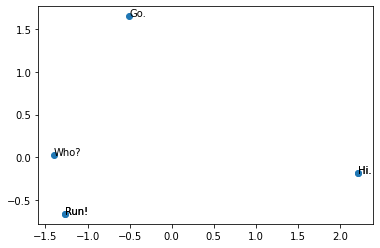

In [365]:
# TODO Predict state for some sentences
i = 0
n = 5

# Sample_sentences = [ ]
sample_sentences = source_sentences[i:i+n+1]

# TODO make make_sequence function
source_sequences = source_tokenizer.texts_to_sequences(sample_sentences)
# Reverse source sequnces
for sequence in source_sequences:
    sequence.reverse()
sample_sequences = pad_sequences(source_sequences, maxlen=max_source_len, padding='pre')

sample_inputs = encoder_model.predict(sample_sequences)[0]

# print(sample_sentences)
# print(sample_inputs)

pca = PCA(n_components=2)
pca.fit(sample_inputs)
pca_inputs = pca.transform(sample_inputs)

plt.scatter(pca_inputs[:,0], pca_inputs[:,1])
for i in range(len(sample_sentences)):
    plt.text(pca_inputs[i,0], pca_inputs[i, 1], sample_sentences[i])

### BLEU score

BLEU (Bilingual Evaluation Understudy) is a score for comparing machine-translated text to one or more reference translations made by a human. Scoring usuall works on indiviual sentences and is then averaged on the entire text. Scores have a value between 0 and 1.

For more info:
- https://en.wikipedia.org/wiki/BLEU
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://towardsdatascience.com/bleu-bilingual-evaluation-understudy-2b4eab9bcfd1

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# References

- https://arxiv.org/abs/1409.3215
- https://arxiv.org/abs/1406.1078
- https://arxiv.org/abs/1609.08144
- https://keras.io/examples/nlp/lstm_seq2seq/
- https://nlp.stanford.edu/projects/glove/